In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

/home/vijay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [3]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [63]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [64]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [65]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [66]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [67]:
# load dataset
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

In [72]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 50

In [73]:
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [74]:
test

array([[ 0.1827063 , -0.15152775,  0.2779048 , -0.6582831 ],
       [-0.15152775,  0.2779048 , -0.6582831 ,  0.37227188],
       [ 0.2779048 , -0.6582831 ,  0.37227188, -0.2986905 ],
       [-0.6582831 ,  0.37227188, -0.2986905 ,  0.00935356],
       [ 0.37227188, -0.2986905 ,  0.00935356,  0.43338183],
       [-0.2986905 ,  0.00935356,  0.43338183, -0.83870297],
       [ 0.00935356,  0.43338183, -0.83870297,  1.        ],
       [ 0.43338183, -0.83870297,  1.        , -1.        ],
       [-0.83870297,  1.        , -1.        ,  0.29993764],
       [ 1.        , -1.        ,  0.29993764,  0.13198919]])

In [75]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

In [76]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
print(forecasts)
print("-----------------------------------------------------")

[[-0.503477, 0.119210646, -0.33315575], [-0.48282856, 0.01975108, 0.090384215], [-0.6096252, 0.16693856, -0.29187053], [0.28856957, -0.16323902, 0.4637525], [0.08497538, -0.11131077, 0.30545843], [-0.042523004, 0.05303639, 0.39864922], [-0.04438991, 0.3147149, 0.14913367], [-0.30626684, 0.5926064, -0.17335922], [0.5227143, -0.41781917, 0.45900273], [-0.72202617, 0.65598744, -0.5938449]]
-----------------------------------------------------


In [77]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
print(forecasts)
print("-----------------------------------------------------")
actual = [row[n_lag:] for row in test]
print(actual)
print("-----------------------------------------------------")
actual = inverse_transform(series, actual, scaler, n_test+2)
print(actual)
print("-----------------------------------------------------")

[[255.03860931396486, 317.56473236083986, 271.27411727905275], [257.4055892944336, 296.00670928955077, 351.59863204956054], [327.6046508789062, 401.6117233276367, 365.2522682189941], [419.1654113769531, 413.74826564788816, 559.1539358139038], [493.590828704834, 500.6650221824646, 607.9930480003356], [424.92108993530275, 471.5289962768555, 601.2740676879882], [460.57200660705564, 570.1266788482666, 639.8507846832275], [535.6775131225586, 712.078987121582, 704.2274284362793], [567.1889282226563, 500.53252563476565, 644.7956329345703], [542.1665954589844, 733.8143768310547, 624.8149871826172]]
-----------------------------------------------------
[array([-0.15152775,  0.2779048 , -0.6582831 ]), array([ 0.2779048 , -0.6582831 ,  0.37227188]), array([-0.6582831 ,  0.37227188, -0.2986905 ]), array([ 0.37227188, -0.2986905 ,  0.00935356]), array([-0.2986905 ,  0.00935356,  0.43338183]), array([ 0.00935356,  0.43338183, -0.83870297]), array([ 0.43338183, -0.83870297,  1.        ]), array([-0.8

In [78]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 98.557213
t+2 RMSE: 91.153182
t+3 RMSE: 110.939474


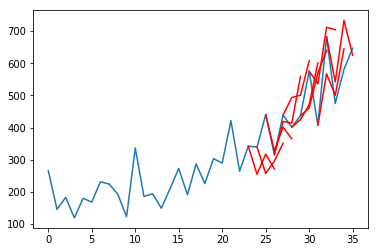

In [79]:
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)